# Clearmap_F1

The purpose of this notebook is to calculate F1 score between a human annotated subvolume and clearmap on SmartSPIM c-fos brains. We want to follow the cross-validation procedure for determining the best hyperparameters of the clearmap code, i.e. filter size, background kernel size, etc... This entails using multiple labeled subvolumes throughout the brain for cross-validation to ensure that our best-fit parameters generalize and are not overtrained. Only then will we run the best-fit, cross-validated parameters on our test set(s). Ideally do a 40 30 30 split for training, cross-val, test or something similar. 

## General imports

In [1]:
import os,sys, glob, shutil, pickle
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import pandas as pd
%matplotlib inline

## Clearmap specific imports

In [2]:
sys.path.append('/jukebox/wang/ahoag/ClearMap2') 

import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ImageProcessing.Experts.Cells as cells

## Load in ground truth human-annotated points for multiple subvolumes  (Neuroglancer CSV format)

In [3]:
vol1_annotation_file = '../data/annotations_zimmerman_01-001_subvol_x1111_y2778_z2500.csv'
vol2_annotation_file = '../data/annotations_zimmerman_01-001_subvol_x4444_y1667_z1500.csv'
vol3_annotation_file = '../data/annotations_zimmerman_01-001_subvol_x1400_y4500_z1150.csv'

In [4]:
df1 = pd.read_csv(vol1_annotation_file)
df2 = pd.read_csv(vol2_annotation_file)
df3 = pd.read_csv(vol3_annotation_file)

In [5]:
df1

Coordinate 1  Coordinate 2  Ellipsoid Dimensions  Description  \
0    (1298, 2843, 2505)           NaN                   NaN          NaN   
1    (1137, 2964, 2504)           NaN                   NaN          NaN   
2    (1183, 2976, 2505)           NaN                   NaN          NaN   
3    (1173, 2825, 2504)           NaN                   NaN          NaN   
4    (1318, 2975, 2505)           NaN                   NaN          NaN   
..                  ...           ...                   ...          ...   
111  (1281, 2888, 2510)           NaN                   NaN          NaN   
112  (1282, 2815, 2524)           NaN                   NaN          NaN   
113  (1306, 2853, 2571)           NaN                   NaN          NaN   
114  (1344, 2897, 2511)           NaN                   NaN          NaN   
115  (1344, 2930, 2543)           NaN                   NaN          NaN   

     Segment IDs  Segment Names   Type  
0            NaN            NaN  Point  
1            NaN            NaN  Point  
2            NaN            NaN  Point  
3            NaN            NaN  Point  
4            NaN            NaN  Point  
..           ...            ...    ...  
111          NaN            NaN  Point  
112          NaN            NaN  Point  
113          NaN            NaN  Point  
114          NaN            NaN  Point  
115          NaN            NaN  Point  

[116 rows x 7 columns]

In [6]:
df2

Coordinate 1  Coordinate 2  Ellipsoid Dimensions  Description  \
0    (4580, 1838, 1500)           NaN                   NaN          NaN   
1    (4637, 1936, 1503)           NaN                   NaN          NaN   
2    (4628, 1937, 1500)           NaN                   NaN          NaN   
3    (4458, 1923, 1504)           NaN                   NaN          NaN   
4    (4573, 1827, 1503)           NaN                   NaN          NaN   
..                  ...           ...                   ...          ...   
271  (4712, 1895, 1552)           NaN                   NaN          NaN   
272  (4472, 1738, 1551)           NaN                   NaN          NaN   
273  (4695, 1938, 1557)           NaN                   NaN          NaN   
274  (4698, 1670, 1563)           NaN                   NaN          NaN   
275  (4504, 1903, 1549)           NaN                   NaN          NaN   

     Segment IDs  Segment Names   Type  
0            NaN            NaN  Point  
1            NaN            NaN  Point  
2            NaN            NaN  Point  
3            NaN            NaN  Point  
4            NaN            NaN  Point  
..           ...            ...    ...  
271          NaN            NaN  Point  
272          NaN            NaN  Point  
273          NaN            NaN  Point  
274          NaN            NaN  Point  
275          NaN            NaN  Point  

[276 rows x 7 columns]

In [23]:
df3

Coordinate 1  Coordinate 2  Ellipsoid Dimensions  Description  \
0   (1450, 4544, 1152)           NaN                   NaN          NaN   
1   (1469, 4728, 1151)           NaN                   NaN          NaN   
2   (1457, 4720, 1151)           NaN                   NaN          NaN   
3   (1576, 4709, 1151)           NaN                   NaN          NaN   
4   (1457, 4506, 1153)           NaN                   NaN          NaN   
5   (1493, 4614, 1161)           NaN                   NaN          NaN   
6   (1453, 4707, 1162)           NaN                   NaN          NaN   
7   (1415, 4536, 1162)           NaN                   NaN          NaN   
8   (1515, 4588, 1164)           NaN                   NaN          NaN   
9   (1603, 4739, 1168)           NaN                   NaN          NaN   
10  (1534, 4594, 1166)           NaN                   NaN          NaN   
11  (1413, 4745, 1173)           NaN                   NaN          NaN   
12  (1435, 4770, 1173)           NaN                   NaN          NaN   
13  (1548, 4611, 1175)           NaN                   NaN          NaN   
14  (1602, 4606, 1182)           NaN                   NaN          NaN   
15  (1461, 4725, 1186)           NaN                   NaN          NaN   
16  (1505, 4652, 1186)           NaN                   NaN          NaN   
17  (1572, 4635, 1190)           NaN                   NaN          NaN   
18  (1461, 4726, 1218)           NaN                   NaN          NaN   
19  (1404, 4565, 1221)           NaN                   NaN          NaN   
20  (1507, 4690, 1222)           NaN                   NaN          NaN   
21  (1440, 4646, 1219)           NaN                   NaN          NaN   
22  (1481, 4559, 1217)           NaN                   NaN          NaN   
23  (1482, 4719, 1214)           NaN                   NaN          NaN   
24  (1527, 4702, 1211)           NaN                   NaN          NaN   
25  (1651, 4723, 1208)           NaN                   NaN          NaN   
26  (1591, 4693, 1203)           NaN                   NaN          NaN   
27  (1512, 4531, 1203)           NaN                   NaN          NaN   
28  (1525, 4737, 1190)           NaN                   NaN          NaN   
29  (1502, 4739, 1190)           NaN                   NaN          NaN   
30  (1547, 4737, 1190)           NaN                   NaN          NaN   
31  (1445, 4594, 1190)           NaN                   NaN          NaN   
32  (1626, 4767, 1188)           NaN                   NaN          NaN   
33  (1569, 4720, 1188)           NaN                   NaN          NaN   
34  (1431, 4670, 1179)           NaN                   NaN          NaN   
35  (1441, 4682, 1176)           NaN                   NaN          NaN   
36  (1533, 4583, 1167)           NaN                   NaN          NaN   
37  (1458, 4681, 1159)           NaN                   NaN          NaN   
38  (1404, 4616, 1157)           NaN                   NaN          NaN   
39  (1591, 4668, 1155)           NaN                   NaN          NaN   
40  (1566, 4775, 1167)           NaN                   NaN          NaN   
41  (1578, 4609, 1167)           NaN                   NaN          NaN   
42  (1523, 4707, 1177)           NaN                   NaN          NaN   
43  (1466, 4609, 1197)           NaN                   NaN          NaN   
44  (1478, 4670, 1197)           NaN                   NaN          NaN   
45  (1601, 4717, 1208)           NaN                   NaN          NaN   
46  (1495, 4608, 1198)           NaN                   NaN          NaN   
47  (1610, 4547, 1208)           NaN                   NaN          NaN   

    Segment IDs  Segment Names   Type  
0           NaN            NaN  Point  
1           NaN            NaN  Point  
2           NaN            NaN  Point  
3           NaN            NaN  Point  
4           NaN            NaN  Point  
5           NaN            NaN  Point  
6           NaN            NaN  Point  
7           Na

## Set up clearmap workspace

In [7]:
directory = os.path.join('/jukebox/wang/ahoag/test_clearmap2/output',
             'cz15/zimmerman_01_smartspim/zimmerman_01-001',
             'imaging_request_1/output')

expression_raw      = 'ch647_renamed/corrected/Z<Z,4>.tif'    

ws = wsp.Workspace('CellMap', directory=directory);
ws.update(raw=expression_raw)
ws.debug=False
ws.info()

Workspace[CellMap]{/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output}
              raw: ch647_renamed/corrected/Z<Z,4>.tif {3589 files, ('Z',): (0,) -> (3588,)}
 autofluorescence: no file
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: resampled.tif
                   resampled_autofluorescence.tif
resampled_to_auto: no file
auto_to_reference: no file
            cells: cells_raw.npy
                   cells_transformed_to_atlas.npy
                   cells_transformed_to_atlas_attempt1.npy
                   cells_transformed_to_atlas_attempt2.npy
                   cells_transformed_to_atlas_attempt3.npy
                   cells_transformed_to_atlas_attempt4.npy
          density: no file



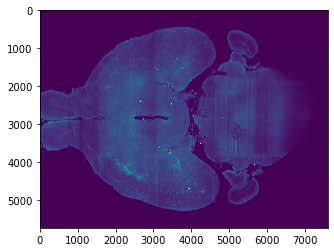

In [10]:
# Make sure the 'stitched' volume is read in OK. You would have created this during cell detection
fig=plt.figure()
ax=fig.add_subplot()
z_plane = ws.source('stitched')[:,:,2500]
ax.imshow(z_plane,vmin=0,vmax=200)


## Make the chunk for subvolume1
Volume starts at (x,y,z) = (1111,2778,2500)

And it is 0.5 mm x 0.5 mm x 0.15 mm in size.
Pixel scale of our volume is 1.8 microns x 1.8 microns x 2 microns so we can calculate the size and extent in pixels of this subvolume cutout from the larger volume

In [39]:
subvol_pix_start = (1111,2778,2500)
mm_subvol=(0.5,0.5,0.15)
microns_per_pix = (1.8,1.8,2) # SmartSPIM 3.6x parameters
microns_subvol = [x*1000 for x in mm_subvol]
# npix_subvol is the number of pixels that the subvolume occupies in x,y,z. Can easily verify this in Neuroglancer
npix_subvol = [int(round(microns_subvol[ii]/microns_per_pix[ii])) for ii in range(3)] 

# Figure out the pixel boundaries of the subvolume within the larger volume
x_start = subvol_pix_start[0]
x_finish = x_start + npix_subvol[0]
y_start = subvol_pix_start[1]
y_finish = y_start + npix_subvol[1]
z_start = subvol_pix_start[2]
z_finish = z_start + npix_subvol[2]
ws.debug = 'subvol_x1111_y2778_z2500' # Set this to the cutout start coordinates
slicing = (slice(x_start,x_finish),slice(y_start,y_finish),slice(z_start,z_finish))
ws.create_debug('stitched', slicing=slicing)  

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1111_y2778_z2500_stitched.npy'

In [40]:
ws.source('stitched').shape # This is the x,y,z shape of the subvolume

(278, 278, 75)

In [41]:
assert list(ws.source('stitched').shape) == npix_subvol

So far so good. Let's try to overlay the points from the annotation csv file onto this subvolume to make sure they line up alright

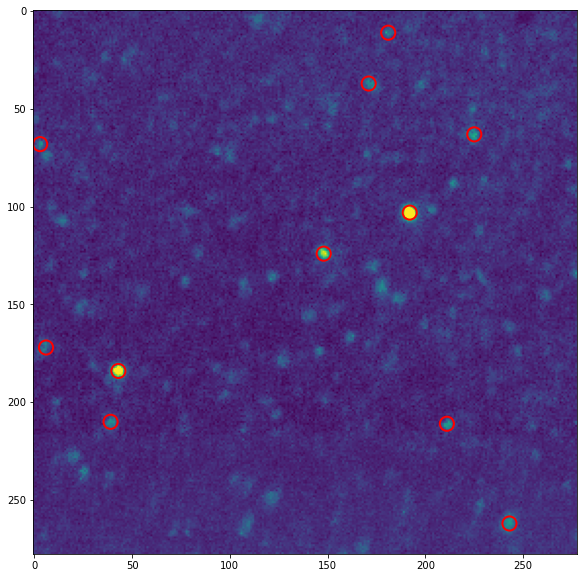

In [42]:
# Grab the points from the pandas dataframe
points1_abs = np.array(list(map(eval,df1['Coordinate 1'].values)))
points1_rel = points1_abs-(x_start,y_start,z_start)

z=24
point_depth = 6 # the number of planes over which a point should be shown 
# Pick out annotated cells within +/- 3 planes of this

zmin=int(np.max([z-point_depth/2.,0]))
zmax=int(np.min([z+point_depth/2.,75]))
maxproj = np.mean(ws.source('stitched')[:,:,zmin:zmax],axis=2)
points1_rel_depth = np.array([point for point in points1_rel if zmin <= point[-1] < zmax])
xs_depth = points1_rel_depth[:,0]
ys_depth = points1_rel_depth[:,1]
points1_rel_depth

fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(111)
ax.imshow(maxproj.T,vmin=0,vmax=200)

ax.scatter(xs_depth,ys_depth,
           color="none",edgecolor='r',
           marker='o',s=200,
          linewidth=2)

Looks good. The annotations match up with the cells and when I compare in Neuroglancer once I shrink the depth to +/-5 microns or so. 

## Parameter sweep to optimize F1 score

In [43]:
from itertools import product
# Here we list the parameter ranges to sweep over.
background_sizes = [5,7,9] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [80,90,100,110,120] 

cell_detection_parameter = cells.default_cell_detection_parameter.copy()
processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )

for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
    this_cell_parameter_dict = cell_detection_parameter.copy()
    this_cell_parameter_dict['background_correction']['shape'] = (background_size,background_size,background_size)
    this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size
    postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    if os.path.exists(ws.filename('cells', postfix=postfix)):
        print("File already exists for this combo of parameters")
        continue
    print(ws.filename('cells', postfix=postfix))
    cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix=postfix),
        cell_detection_parameter=this_cell_parameter_dict,
        processing_parameter=processing_parameter)

File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters


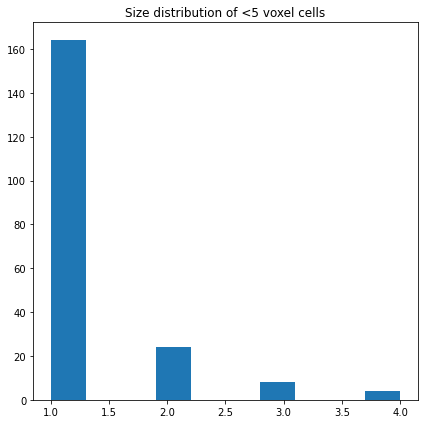

In [49]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.hist(source_tiny['size'])
ax.set_title('Size distribution of <5 voxel cells')
plt.tight_layout()

Some of these are real still but we have to filter at some point. Let's try a sweep and see what the best F1 score we can find is. 

# Sweep over background size, shape threshold size, filter size and compute F1 on training set to figure out neighborhood of good parameters

In [14]:
from scipy.spatial import distance

def compare_clearmap_groundtruth(ground_truth,predicted,cutoff=np.sqrt(27)):
    """ Get tp, fp, and fn by comparing clearmap results to ground truth
    ---INPUT---
    cutoff -- only keep pairs that are less than this many voxels off. 
    This is a 3 pixel volume neighborhood: sqrt(3^2+3^2+3^2)
    """
    cdists=distance.cdist(ground_truth, predicted, metric="euclidean")
    truth_indices,pred_indices = np.where(cdists <= cutoff)
    dists = zip(cdists[truth_indices,pred_indices],truth_indices,pred_indices)
    #sort by smallest dist
    dists=sorted(dists, key=lambda x: x[0])

    used_truth = set()
    used_pred = set()
    paired = []
    for (i,dist) in enumerate(dists):
        d = dist[0]
        if d > cutoff:
            #we have reached distances beyond the cutoff
            if verbose: print("Reached cutoff distance, so far {} paired".format(len(paired)))
            break
        truth_idx = dist[1]
        pred_idx = dist[2]
        if truth_idx not in used_truth and pred_idx not in used_pred:
            paired.append((truth_idx,pred_idx,d))
            used_truth.add(truth_idx)
            used_pred.add(pred_idx)
        if len(used_truth) == len(ground_truth) or len(used_pred) == len(predicted):
            # we have used up all the entries from the shorter list
            break

    tp = len(paired)
    fn = len(ground_truth) - len(paired)
    fp = len(predicted) - len(paired)
    return tp,fp,fn

def precision(tp,fp):
    return float(tp / (tp + fp))

def recall(tp,fn):
    return float(tp / (tp + fn))

def f1(tp,fp,fn):
    p = precision(tp,fp)
    r = recall(tp,fn)
    return float(2*p*r/(p+r))

In [45]:
ground_truth = points1_rel
ground_truth_eroded = np.array([x for x in ground_truth if edge_erode_pix < x[0] < (x_max-edge_erode_pix) and \
         edge_erode_pix < x[1] < (y_max-edge_erode_pix) and edge_erode_pix < x[2] < (z_max-edge_erode_pix)])
# background_sizes = [3,5,7] # will make xy tuples like: (5,5), (7,7), (9,9)  
background_sizes = [5,7,9] # will make xy tuples like: (5,5), (7,7), (9,9)  
# shape_threshold_sizes = [50,75,100,125,150]
shape_threshold_sizes = [80,90,100,110,120]

filter_min_thresholds = [10,12,14,16,18,20,22,24,26,28,30]
param_list = list(product(filter_min_thresholds,background_sizes,shape_threshold_sizes))
# param_list = list(product(background_sizes,shape_threshold_sizes))
precision_array_eroded = np.zeros(len(param_list))
recall_array_eroded = np.zeros(len(param_list))
f1_array_eroded = np.zeros(len(param_list))
# print("#filter_min_thresh, background_size, shape_threshold_size, N_detected, Precision, Recall, F1_score:")

edge_erode_pix = 3 # in each dimension
x_max,y_max,z_max = ws.source('stitched').shape

counter = 0

for filter_min_threshold,background_size,shape_threshold_size in param_list:
# for background_size,shape_threshold_size in param_list:
    postfix_source = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    postfix_sink = f'raw_bck{background_size}_shpthresh{shape_threshold_size}_greaterthan{filter_min_threshold}voxels'
#     postfix_sink = f'raw_bck{background_size}_shpthresh{shape_threshold_size}_lessthan'
    thresholds = {'size' : (filter_min_threshold,1000) }
    filtered_postfix = postfix + '_lessthan5voxels'
    if not os.path.exists(ws.filename('cells', postfix=postfix_sink)):
        cells.filter_cells(source = ws.filename('cells', postfix=postfix_source), 
                           sink = ws.filename('cells', postfix=postfix_sink),
                           thresholds=thresholds);
    source = ws.source('cells', postfix=postfix_sink)
    predicted_points_clearmap = np.hstack([source[c][:,None] for c in 'xyz'])
    predicted_points_clearmap_eroded = np.array([x for x in predicted_points_clearmap if edge_erode_pix < x[0] < (x_max-edge_erode_pix) and \
         edge_erode_pix < x[1] < (y_max-edge_erode_pix) and edge_erode_pix < x[2] < (z_max-edge_erode_pix)])
    
    tp_eroded,fp_eroded,fn_eroded = compare_clearmap_groundtruth(ground_truth_eroded,
                                                             predicted=predicted_points_clearmap_eroded)
    p_eroded=precision(tp_eroded,fp_eroded)
    r_eroded=recall(tp_eroded,fn_eroded)
    f1_score_eroded=f1(tp_eroded,fp_eroded,fn_eroded)
    precision_array_eroded[counter] = p_eroded
    recall_array_eroded[counter] = r_eroded
    f1_array_eroded[counter] = f1_score_eroded
#     index_dict[counter] = [background_size,shape_threshold_size]
    counter+=1

/usr/people/ahoag/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


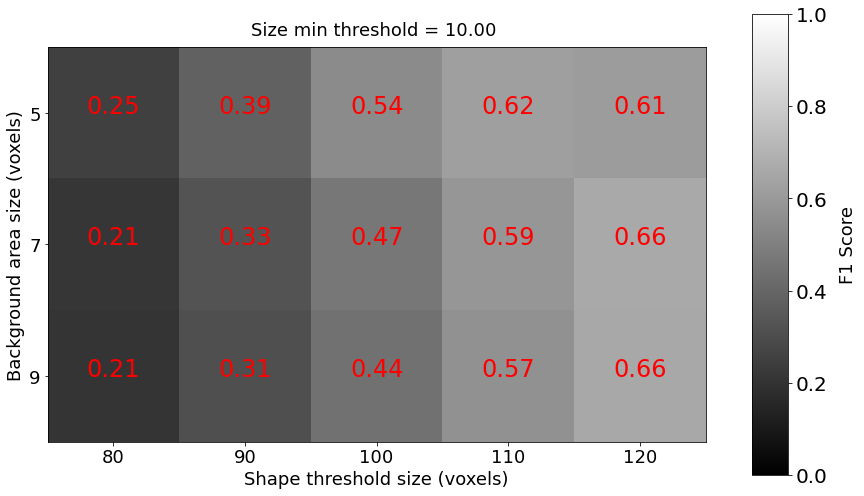

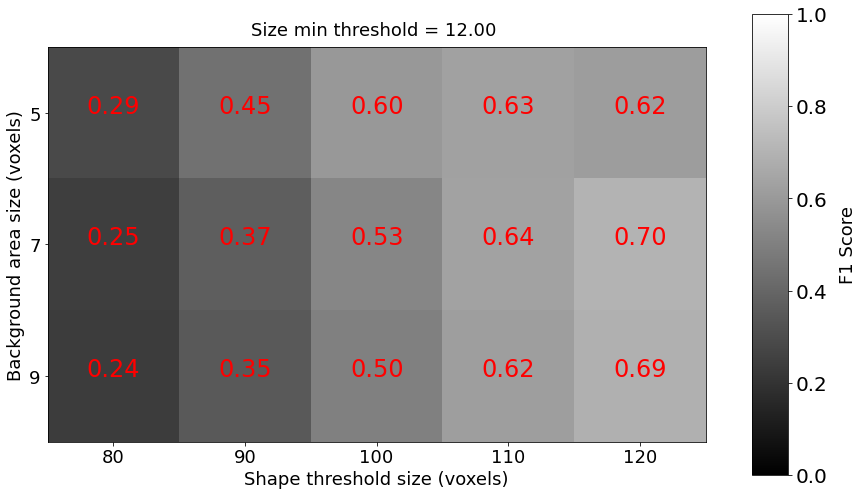

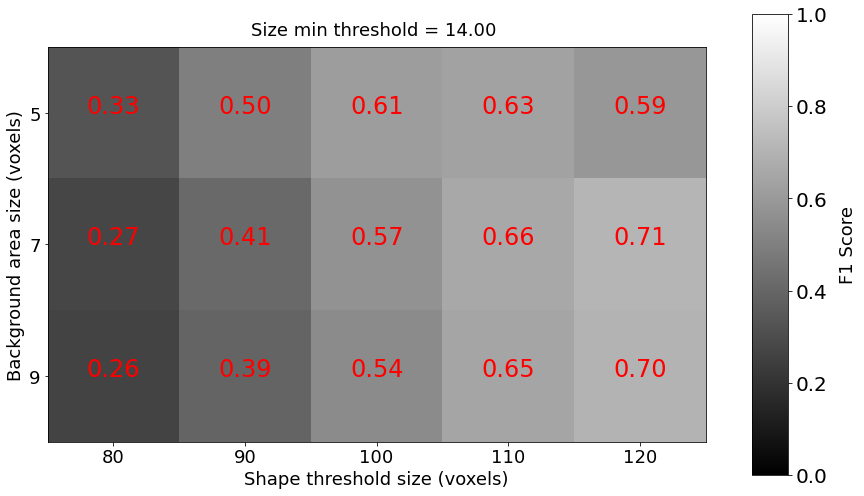

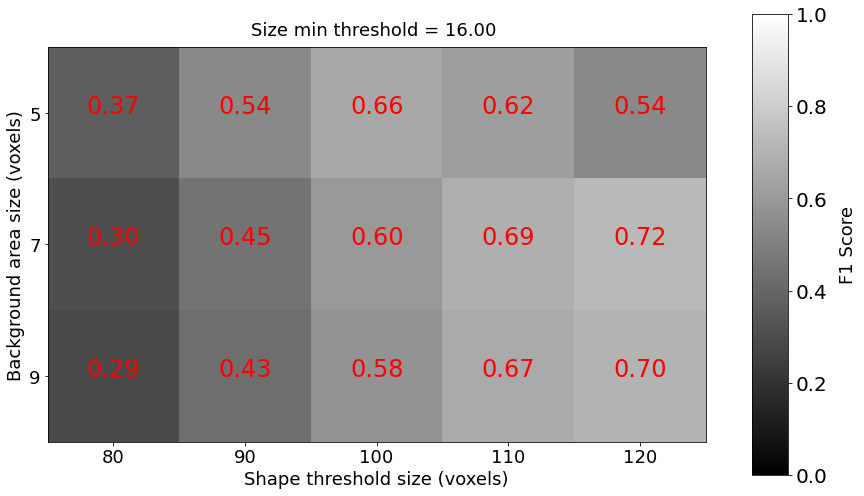

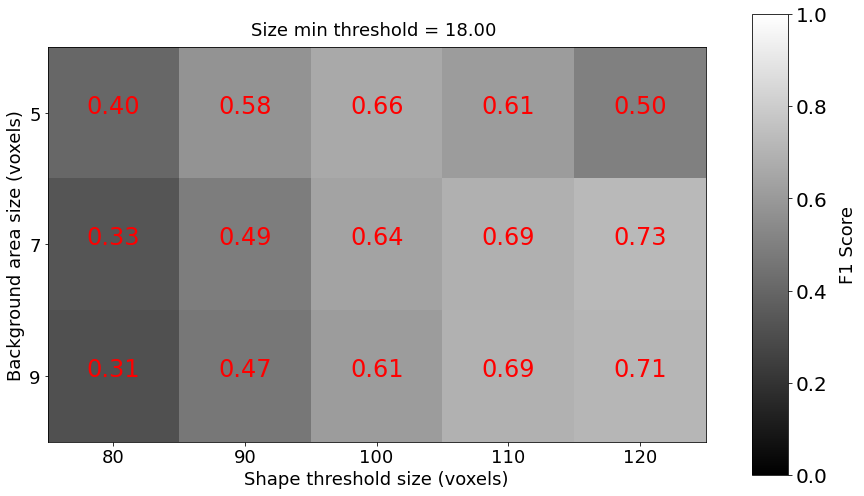

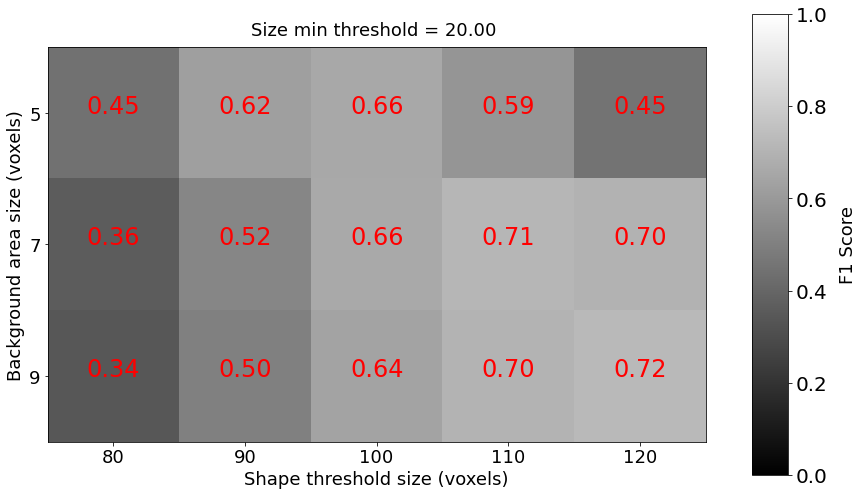

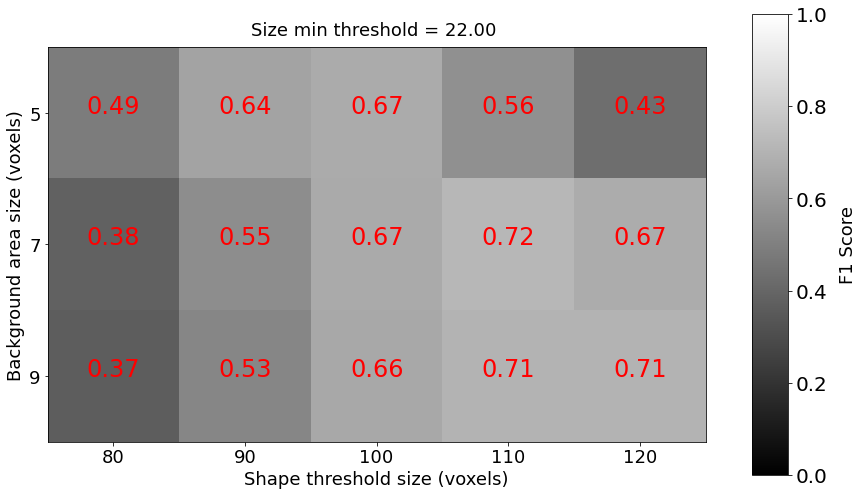

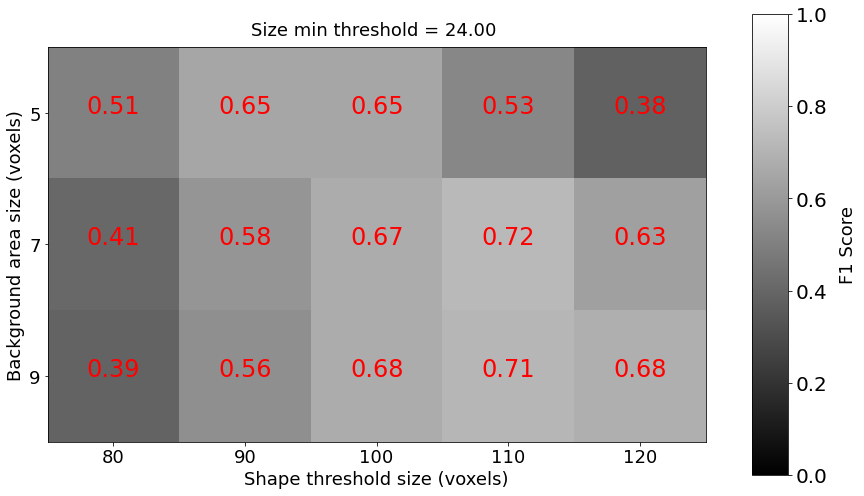

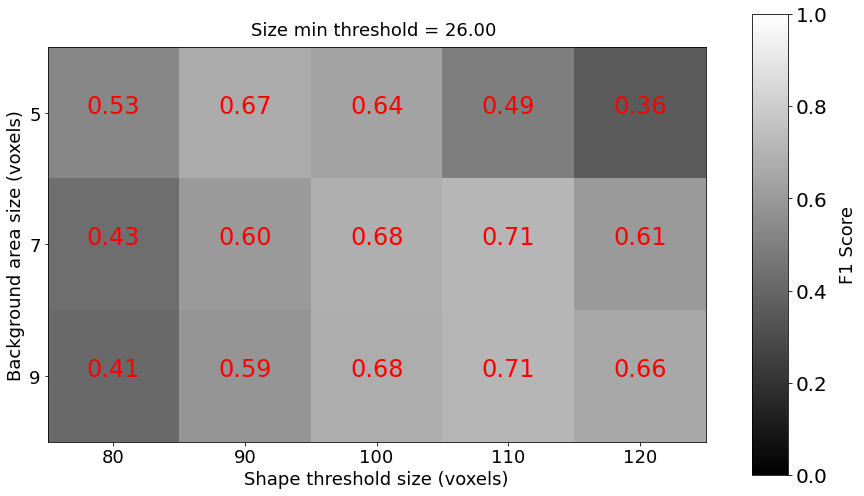

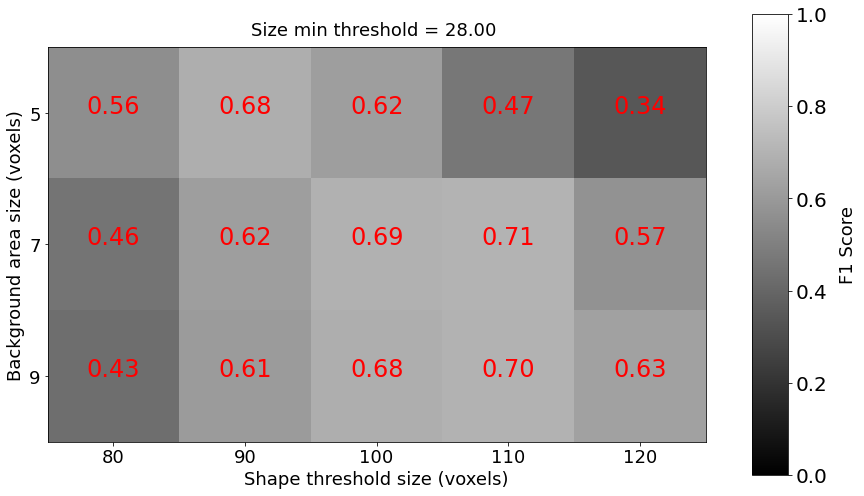

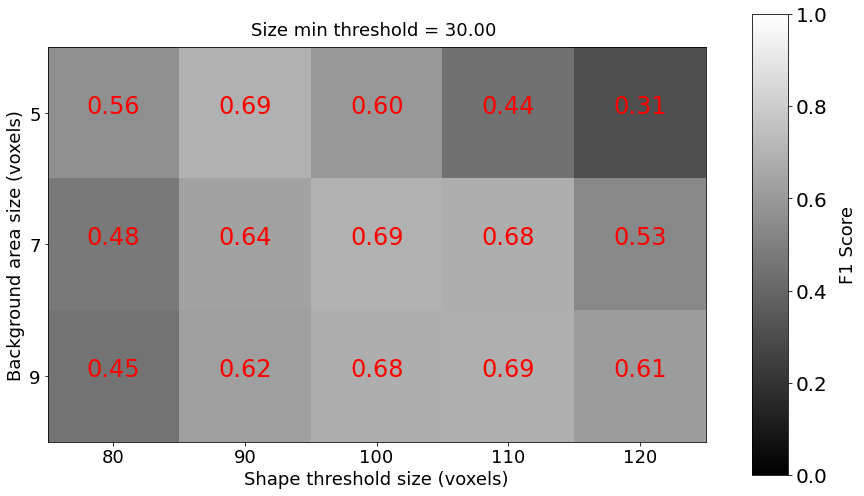

In [37]:
f1_images_eroded=f1_array_eroded.reshape(len(filter_min_thresholds),len(background_sizes),len(shape_threshold_sizes))

fontsize=18

for kk in range(len(f1_images_eroded)):
    filter_min_threshold = filter_min_thresholds[kk]
    f1_image = f1_images_eroded[kk]
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111)
    ax.set_title(f'Size min threshold = {filter_min_threshold:.2f} ',fontsize=fontsize,pad=12)
    im=ax.imshow(f1_image,vmin=0,vmax=1,cmap='gray')
    ax.set_xlabel('Shape threshold size (voxels)',fontsize=fontsize)
    ax.set_ylabel('Background area size (voxels)',fontsize=fontsize)
    ax.set_xticks(range(len(shape_threshold_sizes)))
    ax.set_xticklabels(shape_threshold_sizes)

    ax.set_yticks(range(len(background_sizes)))
    ax.set_yticklabels(background_sizes)

    # Tick labels
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)

    # Colorbar
    cax = fig.add_axes([1.05, 0.1, 0.05, 0.8])

    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel('F1 Score',fontsize=fontsize,labelpad=12)
    plt.tight_layout()
    for ii in range(len(background_sizes)):
        for jj in range(len(shape_threshold_sizes)):
            f1_score = f1_image[ii][jj]
            ax.text(jj,ii,f'{f1_score:.2f}',color='r',
                    fontsize=24,horizontalalignment="center")


Get up to 81% F1 score with edge erosion. Is the false positive rate better?

In [46]:
best_mask_eroded_subvol1=np.where(f1_array_eroded==f1_array_eroded.max())[0][0]
best_f1_score_eroded = f1_array_eroded[best_mask_eroded_subvol1]
best_precision_eroded = precision_array_eroded[best_mask_eroded_subvol1]
best_recall_eroded = recall_array_eroded[best_mask_eroded_subvol1]
print(f"Best F1 score: {best_f1_score_eroded:.2f}, Precision = {best_precision_eroded:.2f}, Recall = {best_recall_eroded:.2f}")

Best F1 score: 0.81, Precision = 0.78, Recall = 0.83


# TP FP FN
   7 2 6
   6 3 6
   8 3 4
   10 4 5


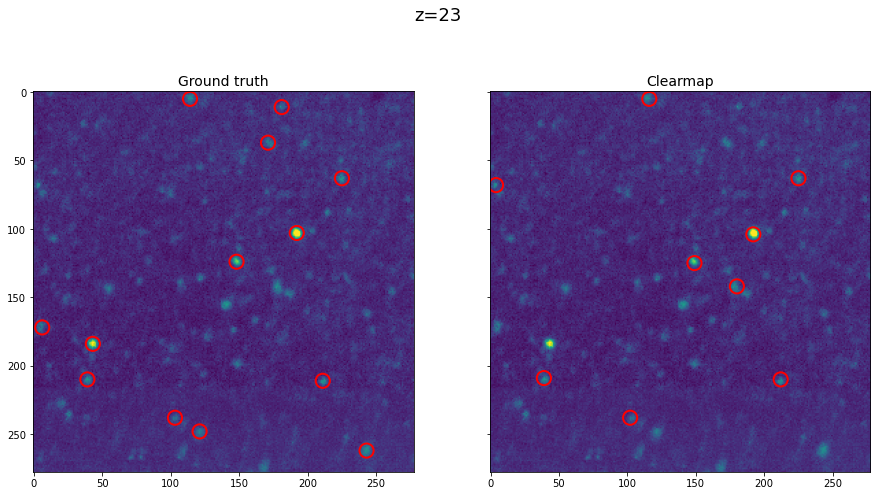

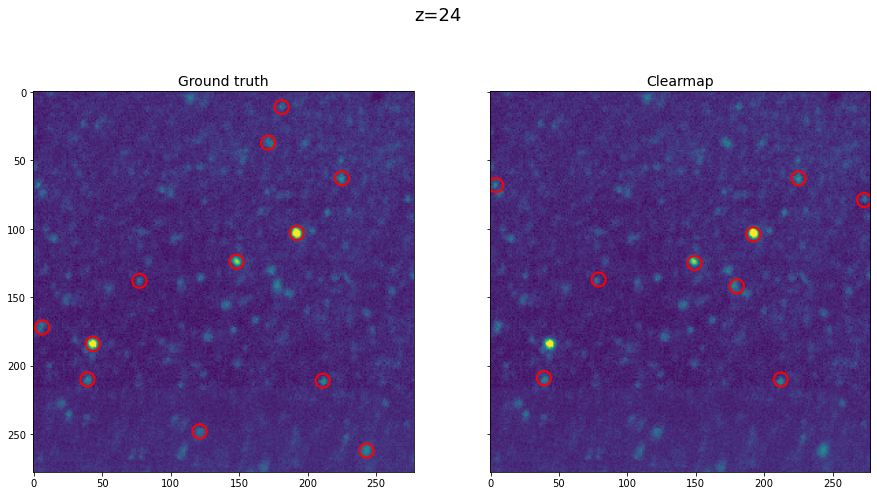

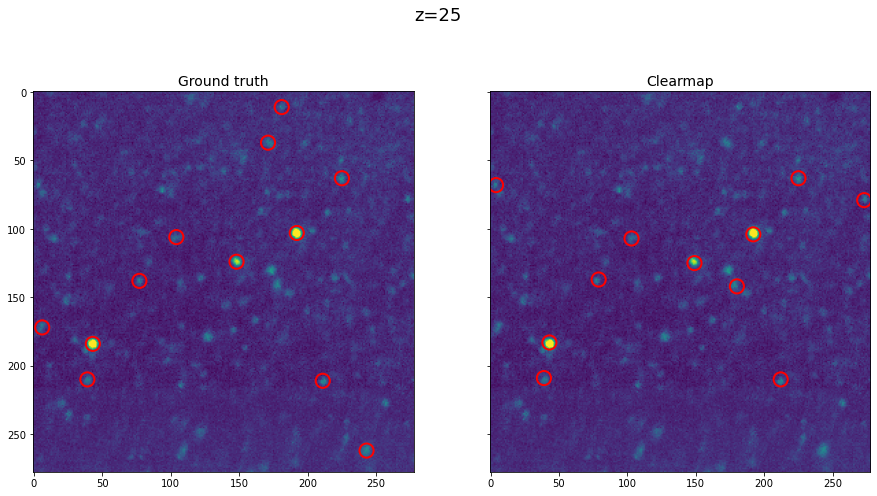

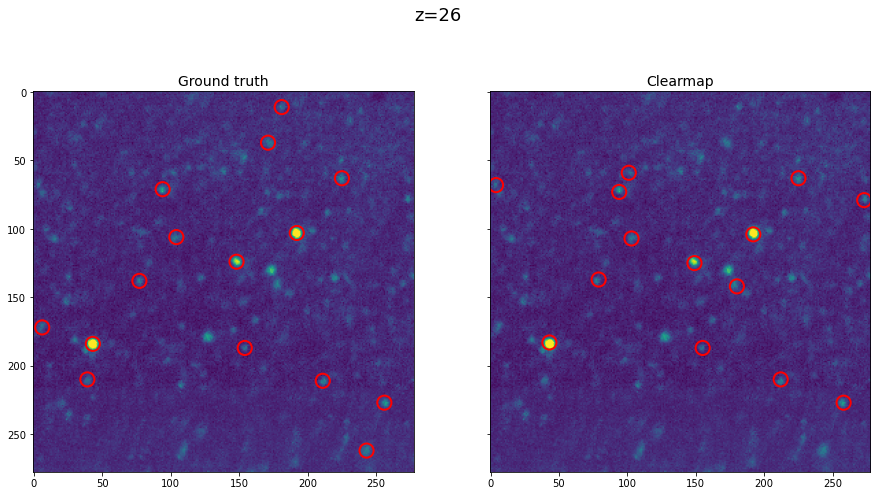

In [34]:
filter_min_thresh_best = 26
background_size_best = 9
shape_threshold_size_best = 90

postfix_best = f'raw_bck{background_size_best}_shpthresh{shape_threshold_size_best}_greaterthan{filter_min_thresh_best}voxels'

source_best = ws.source('cells', postfix=postfix_best)
points1_clearmap_best = np.hstack([source_best[c][:,None] for c in 'xyz'])

print("# TP FP FN")
point_depth = 8
for z in range(23,27):
    zmin=int(np.max([z-point_depth/2.,0]))
    zmax=int(np.min([z+point_depth/2.,75]))
    maxproj = np.mean(ws.source('stitched')[:,:,zmin:zmax],axis=2)

    points1_clearmap_best_depth = np.array([coord for coord in points1_clearmap_best if coord[-1] < zmax and coord[-1] >=zmin])
    points1_clearmap_best_depth_eroded = np.array([x for x in points1_clearmap_best_depth if edge_erode_pix < x[0] < (x_max-edge_erode_pix) and \
         edge_erode_pix < x[1] < (y_max-edge_erode_pix) and edge_erode_pix < x[2] < (z_max-edge_erode_pix)])
    
    xs_clearmap_depth_eroded = points1_clearmap_best_depth_eroded[:,0]
    ys_clearmap_depth_eroded = points1_clearmap_best_depth_eroded[:,1]
    
    points1_rel_depth = np.array([point for point in ground_truth_eroded if point[-1] < zmax and point[-1] >=zmin])
    xs_depth = points1_rel_depth[:,0]
    ys_depth = points1_rel_depth[:,1]
    
    tp,fp,fn =  compare_clearmap_groundtruth(ground_truth=points1_rel_depth,
                                             predicted=points1_clearmap_best_depth_eroded,
                                             cutoff=np.sqrt(27))     
    print("  ",tp,fp,fn)
    fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
    fig.suptitle(f"z={z}",fontsize=18)
    ax_annot = axes[0]
    ax_annot.set_title("Ground truth",fontsize=14)
    ax_annot.imshow(maxproj.T,vmin=0,vmax=200,cmap='viridis')
    ax_annot.scatter(xs_depth,ys_depth,
               color="none",edgecolor='r',
               marker='o',s=200,
              linewidth=2)
    
    ax_clearmap=axes[1]
    ax_clearmap.set_title("Clearmap",fontsize=14)
    ax_clearmap.imshow(maxproj.T,vmin=0,vmax=200,cmap='viridis')
    ax_clearmap.scatter(xs_clearmap_depth_eroded,ys_clearmap_depth_eroded,
                        s=200,facecolors='none',edgecolors='r',
                       marker='o',linewidth=2)

## Cross-validate these parameters on subvolumes 2 and 3

In [35]:
ls ../data/

annotations_zimmerman_01-001_subvol_x1111_y2778_z2500.csv
annotations_zimmerman_01-001_subvol_x1400_y4500_z1150.csv
annotations_zimmerman_01-001_subvol_x4444_y1667_z1500.csv


In [47]:
subvol_pix_start = (4444,1667,1500)
mm_subvol=(0.5,0.5,0.15)
microns_per_pix = (1.8,1.8,2) # SmartSPIM 3.6x parameters
microns_subvol = [x*1000 for x in mm_subvol]
# npix_subvol is the number of pixels that the subvolume occupies in x,y,z. Can easily verify this in Neuroglancer
npix_subvol = [int(round(microns_subvol[ii]/microns_per_pix[ii])) for ii in range(3)] 

# Figure out the pixel boundaries of the subvolume within the larger volume
x_start = subvol_pix_start[0]
x_finish = x_start + npix_subvol[0]
y_start = subvol_pix_start[1]
y_finish = y_start + npix_subvol[1]
z_start = subvol_pix_start[2]
z_finish = z_start + npix_subvol[2]
ws.debug = 'subvol_x4444_y1667_z1500' # Set this to the cutout start coordinates
slicing = (slice(x_start,x_finish),slice(y_start,y_finish),slice(z_start,z_finish))
ws.create_debug('stitched', slicing=slicing)  

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x4444_y1667_z1500_stitched.npy'

In [37]:
ws.source('stitched').shape

(278, 278, 75)

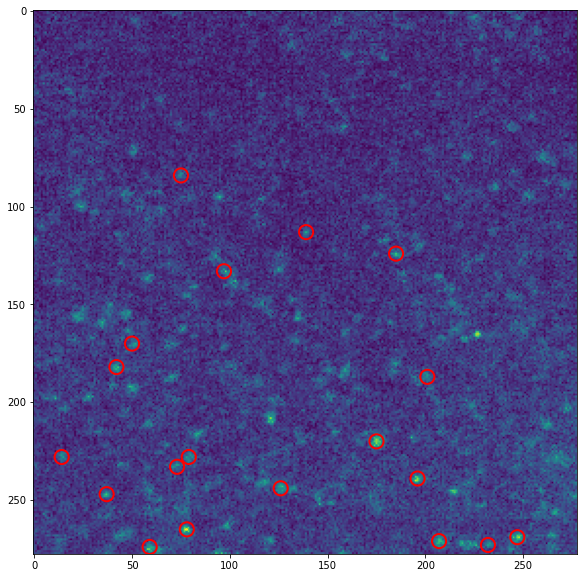

In [48]:
# Grab the points from the pandas dataframe
points2_abs = np.array(list(map(eval,df2['Coordinate 1'].values)))
points2_rel = points2_abs-(x_start,y_start,z_start)
z=24
point_depth = 6 # the number of planes over which a point should be shown 
# Pick out annotated cells within +/- 3 planes of this

zmin=int(np.max([z-point_depth/2.,0]))
zmax=int(np.min([z+point_depth/2.,75]))
maxproj = np.mean(ws.source('stitched')[:,:,zmin:zmax],axis=2)
points2_rel_depth = np.array([point for point in points2_rel if zmin <= point[-1] < zmax])
xs_depth = points2_rel_depth[:,0]
ys_depth = points2_rel_depth[:,1]
points2_rel_depth

fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(111)
ax.imshow(maxproj.T,vmin=0,vmax=200)

ax.scatter(xs_depth,ys_depth,
           color="none",edgecolor='r',
           marker='o',s=200,
          linewidth=2)

Looks like the coordinates loaded in correctly. Now let's run the cell detector on this new subvolume over the range of parameters

In [49]:
from itertools import product
# Here we list the parameter ranges to sweep over.
background_sizes = [5,7,9] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [80,90,100,110,120] 

cell_detection_parameter = cells.default_cell_detection_parameter.copy()
processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )

for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
    this_cell_parameter_dict = cell_detection_parameter.copy()
    this_cell_parameter_dict['background_correction']['shape'] = (background_size,background_size,background_size)
    this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size
    postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    if os.path.exists(ws.filename('cells', postfix=postfix)):
        print("File already exists for this combo of parameters")
        continue
    print(ws.filename('cells', postfix=postfix))
    cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix=postfix),
        cell_detection_parameter=this_cell_parameter_dict,
        processing_parameter=processing_parameter)

File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters
File already exists for this combo of parameters


In [50]:
ground_truth = points2_rel
edge_erode_pix = 3
x_max,y_max,z_max = ws.source('stitched').shape

ground_truth_eroded = np.array([x for x in ground_truth if edge_erode_pix < x[0] < (x_max-edge_erode_pix) and \
         edge_erode_pix < x[1] < (y_max-edge_erode_pix) and edge_erode_pix < x[2] < (z_max-edge_erode_pix)])
background_sizes = [5,7,9] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [80,90,100,110,120]

filter_min_thresholds = [10,12,14,16,18,20,22,24,26,28,30]
param_list = list(product(filter_min_thresholds,background_sizes,shape_threshold_sizes))
precision_array_eroded = np.zeros(len(param_list))
recall_array_eroded = np.zeros(len(param_list))
f1_array_eroded = np.zeros(len(param_list))

edge_erode_pix = 3 # in each dimension

counter = 0

for filter_min_threshold,background_size,shape_threshold_size in param_list:
    postfix_source = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    postfix_sink = f'raw_bck{background_size}_shpthresh{shape_threshold_size}_greaterthan{filter_min_threshold}voxels'
    thresholds = {'size' : (filter_min_threshold,1000) }
    filtered_postfix = postfix + '_lessthan5voxels'
    if not os.path.exists(ws.filename('cells', postfix=postfix_sink)):
        cells.filter_cells(source = ws.filename('cells', postfix=postfix_source), 
                           sink = ws.filename('cells', postfix=postfix_sink),
                           thresholds=thresholds);
    source = ws.source('cells', postfix=postfix_sink)
    predicted_points_clearmap = np.hstack([source[c][:,None] for c in 'xyz'])
    predicted_points_clearmap_eroded = np.array([x for x in predicted_points_clearmap if edge_erode_pix < x[0] < (x_max-edge_erode_pix) and \
         edge_erode_pix < x[1] < (y_max-edge_erode_pix) and edge_erode_pix < x[2] < (z_max-edge_erode_pix)])
    
    tp_eroded,fp_eroded,fn_eroded = compare_clearmap_groundtruth(ground_truth_eroded,
                                                             predicted=predicted_points_clearmap_eroded)
    p_eroded=precision(tp_eroded,fp_eroded)
    r_eroded=recall(tp_eroded,fn_eroded)
    f1_score_eroded=f1(tp_eroded,fp_eroded,fn_eroded)
    precision_array_eroded[counter] = p_eroded
    recall_array_eroded[counter] = r_eroded
    f1_array_eroded[counter] = f1_score_eroded
    counter+=1

In [51]:
f1_array_eroded.max()

0.726457399103139

/usr/people/ahoag/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


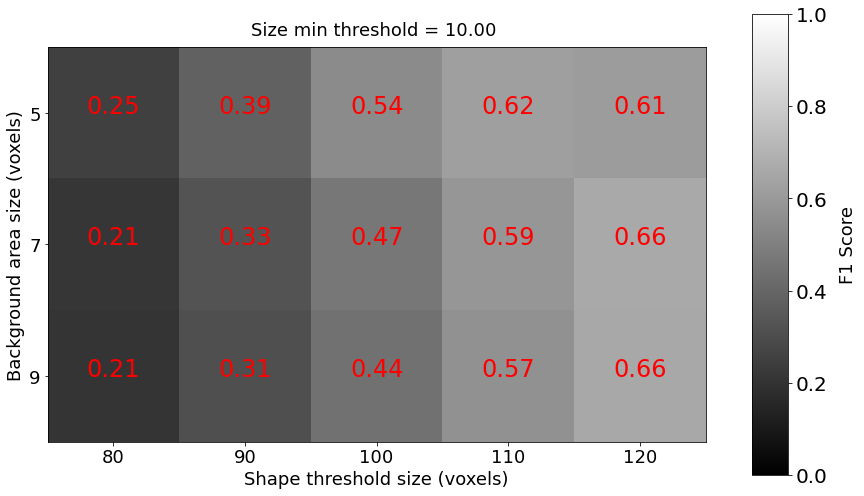

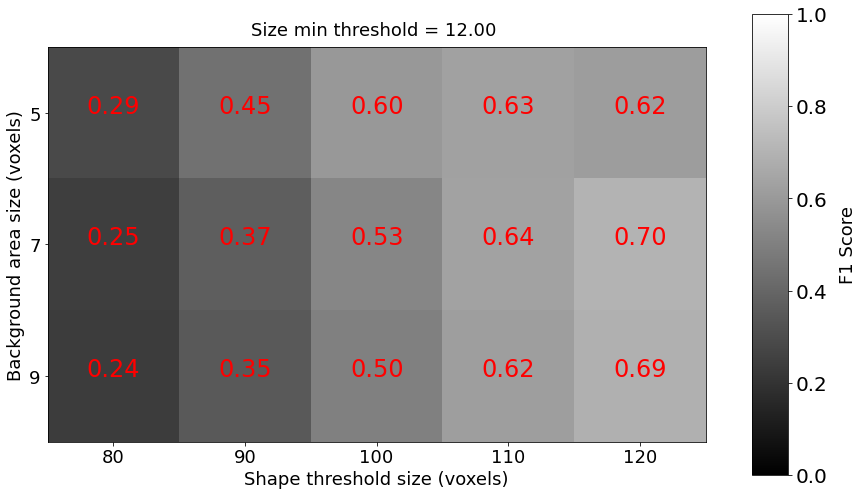

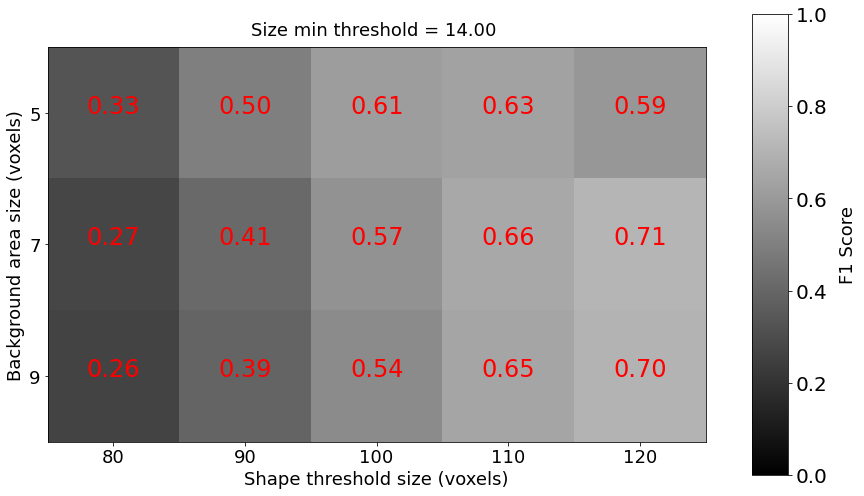

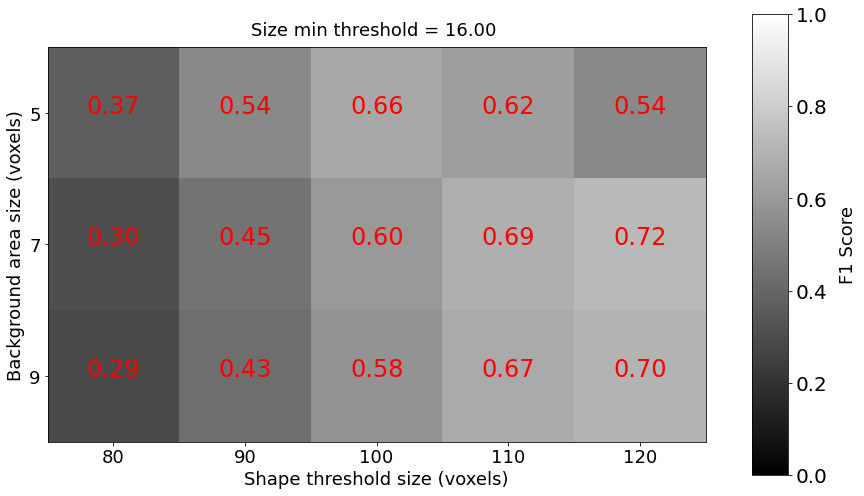

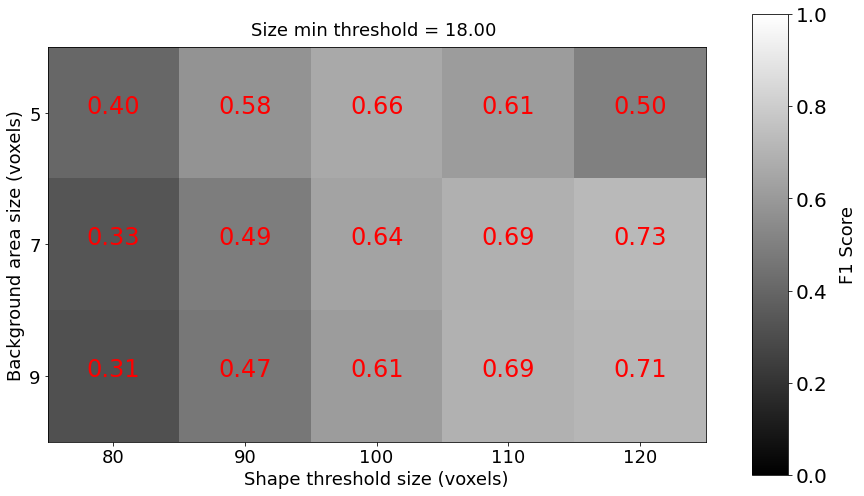

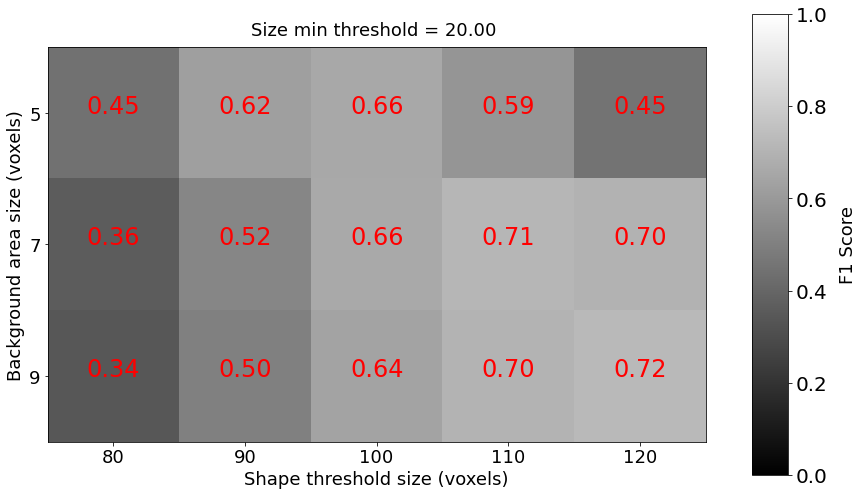

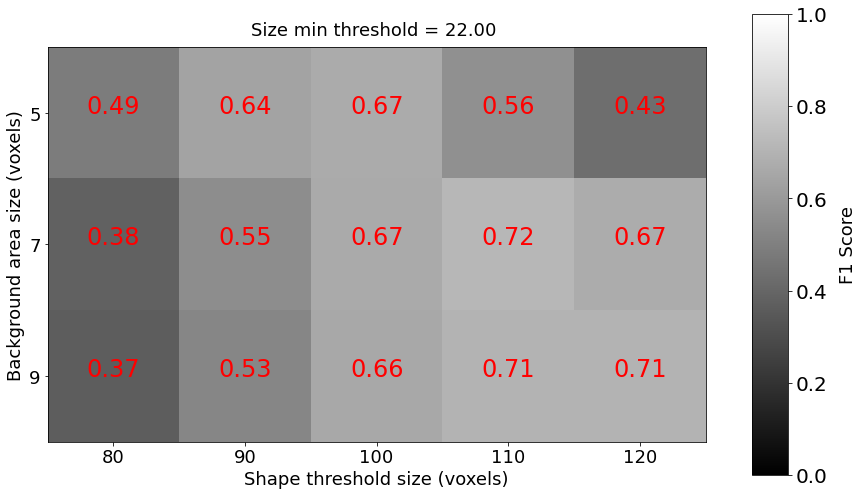

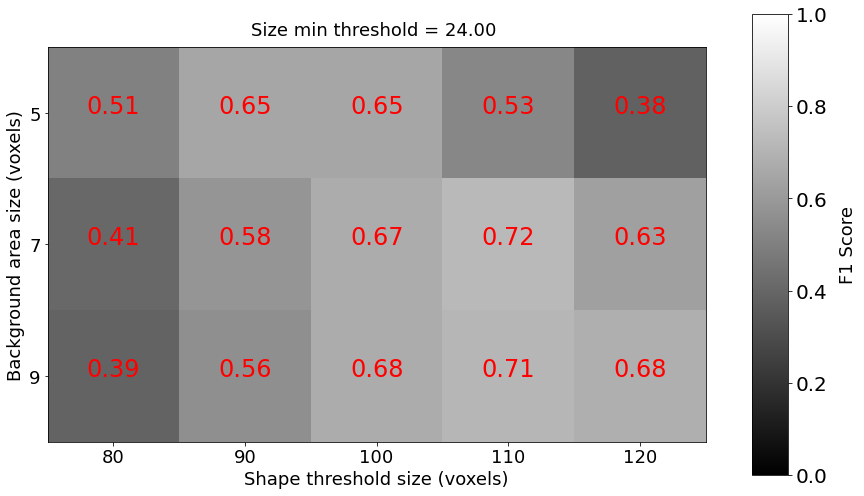

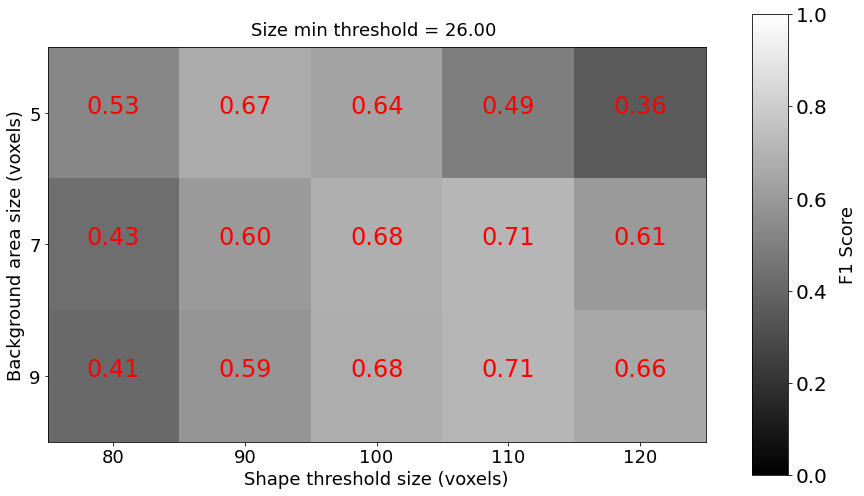

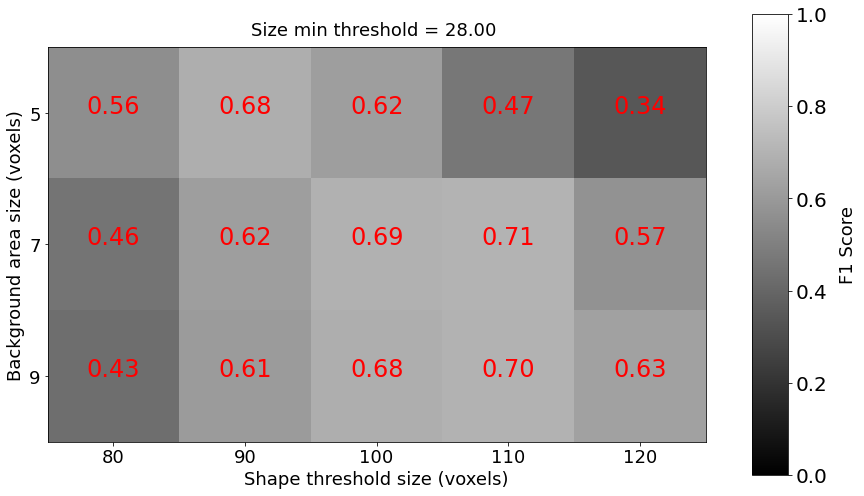

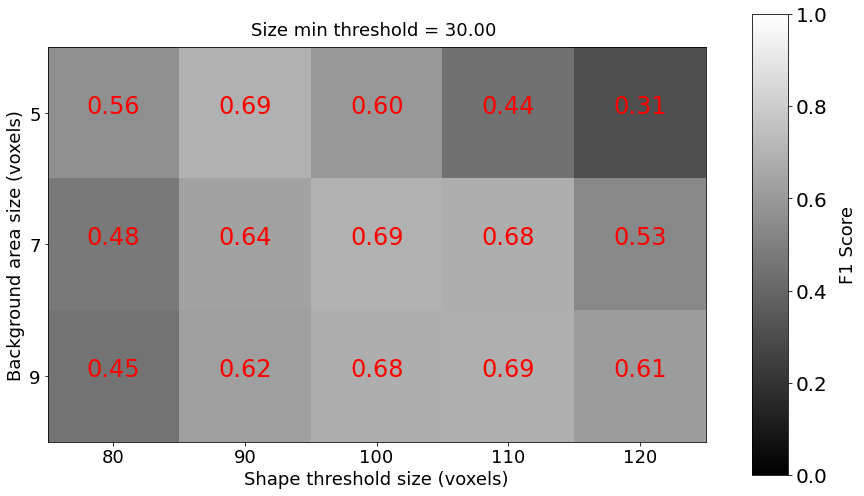

In [17]:
f1_images_eroded=f1_array_eroded.reshape(len(filter_min_thresholds),len(background_sizes),len(shape_threshold_sizes))

fontsize=18

for kk in range(len(f1_images_eroded)):
    filter_min_threshold = filter_min_thresholds[kk]
    f1_image = f1_images_eroded[kk]
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111)
    ax.set_title(f'Size min threshold = {filter_min_threshold:.2f} ',fontsize=fontsize,pad=12)
    im=ax.imshow(f1_image,vmin=0,vmax=1,cmap='gray')
    ax.set_xlabel('Shape threshold size (voxels)',fontsize=fontsize)
    ax.set_ylabel('Background area size (voxels)',fontsize=fontsize)
    ax.set_xticks(range(len(shape_threshold_sizes)))
    ax.set_xticklabels(shape_threshold_sizes)

    ax.set_yticks(range(len(background_sizes)))
    ax.set_yticklabels(background_sizes)

    # Tick labels
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)

    # Colorbar
    cax = fig.add_axes([1.05, 0.1, 0.05, 0.8])

    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel('F1 Score',fontsize=fontsize,labelpad=12)
    plt.tight_layout()
    for ii in range(len(background_sizes)):
        for jj in range(len(shape_threshold_sizes)):
            f1_score = f1_image[ii][jj]
            ax.text(jj,ii,f'{f1_score:.2f}',color='r',
                    fontsize=24,horizontalalignment="center")

What F1 score do we get using best-fit params from previous subvolume?

In [54]:
f1_score_subvol2 = f1_array_eroded[best_mask_subvol1]
precision_subvol2 = precision_array_eroded[best_mask_subvol1]
recall_subvol2 = recall_array_eroded[best_mask_subvol1]
print(f"Scores using best-fit params from subvol1 on subvol2:\n F1 score: {f1_score_subvol2:.2f}, Precision = {precision_subvol2:.2f}, Recall = {recall_subvol2:.2f}")

Scores using best-fit params from subvol1 on subvol2:
 F1 score: 0.59, Precision = 0.43, Recall = 0.93


## Subvolume 3

In [56]:
ls ../data

annotations_zimmerman_01-001_subvol_x1111_y2778_z2500.csv
annotations_zimmerman_01-001_subvol_x1400_y4500_z1150.csv
annotations_zimmerman_01-001_subvol_x4444_y1667_z1500.csv


In [57]:
subvol_pix_start = (1400,4500,1150)
mm_subvol=(0.5,0.5,0.15)
microns_per_pix = (1.8,1.8,2) # SmartSPIM 3.6x parameters
microns_subvol = [x*1000 for x in mm_subvol]
# npix_subvol is the number of pixels that the subvolume occupies in x,y,z. Can easily verify this in Neuroglancer
npix_subvol = [int(round(microns_subvol[ii]/microns_per_pix[ii])) for ii in range(3)] 

# Figure out the pixel boundaries of the subvolume within the larger volume
x_start = subvol_pix_start[0]
x_finish = x_start + npix_subvol[0]
y_start = subvol_pix_start[1]
y_finish = y_start + npix_subvol[1]
z_start = subvol_pix_start[2]
z_finish = z_start + npix_subvol[2]
ws.debug = 'subvol_x1400_y4500_z1150' # Set this to the cutout start coordinates
slicing = (slice(x_start,x_finish),slice(y_start,y_finish),slice(z_start,z_finish))
ws.create_debug('stitched', slicing=slicing)  

'/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_stitched.npy'

In [59]:
ws.source('stitched').shape

(278, 278, 75)

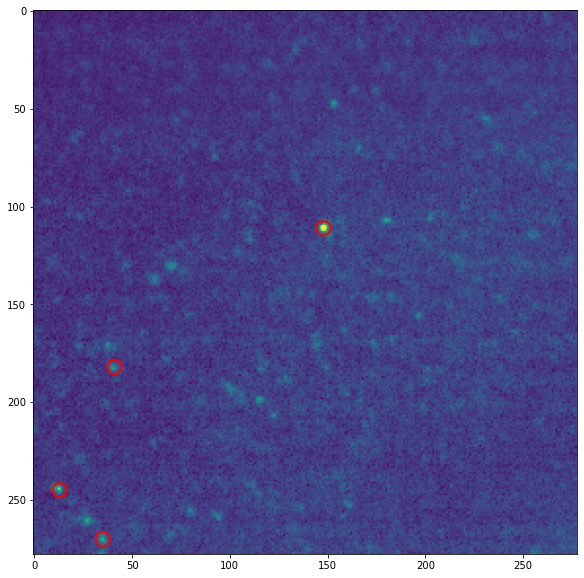

In [64]:
# Grab the points from the pandas dataframe
points3_abs = np.array(list(map(eval,df3['Coordinate 1'].values)))
points3_rel = points3_abs-(x_start,y_start,z_start)
z=24
point_depth = 6 # the number of planes over which a point should be shown 
# Pick out annotated cells within +/- 3 planes of this

zmin=int(np.max([z-point_depth/2.,0]))
zmax=int(np.min([z+point_depth/2.,75]))
maxproj = np.mean(ws.source('stitched')[:,:,zmin:zmax],axis=2)
point3_rel_depth = np.array([point for point in point3_rel if zmin <= point[-1] < zmax])
xs_depth = point3_rel_depth[:,0]
ys_depth = point3_rel_depth[:,1]
point3_rel_depth

fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(111)
ax.imshow(maxproj.T,vmin=0,vmax=200)

ax.scatter(xs_depth,ys_depth,
           color="none",edgecolor='r',
           marker='o',s=200,
          linewidth=2)

Looks good

In [61]:
from itertools import product
# Here we list the parameter ranges to sweep over.
background_sizes = [5,7,9] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [80,90,100,110,120] 

cell_detection_parameter = cells.default_cell_detection_parameter.copy()
processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )

for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
    this_cell_parameter_dict = cell_detection_parameter.copy()
    this_cell_parameter_dict['background_correction']['shape'] = (background_size,background_size,background_size)
    this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size
    postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    if os.path.exists(ws.filename('cells', postfix=postfix)):
        print("File already exists for this combo of parameters")
        continue
    print(ws.filename('cells', postfix=postfix))
    cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix=postfix),
        cell_detection_parameter=this_cell_parameter_dict,
        processing_parameter=processing_parameter)

/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck5_shpthresh80.npy
Processing 1 blocks with function 'detect_cells_block'.
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Background removal shape: (5, 5, 5)
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Background removal form : Disk
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Background removal save : False
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Illumination correction: elapsed time: 0:00:00.148
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: DoG filter: shape : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: DoG filter: sigma : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(2

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.668
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.829
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.387
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.768
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.932
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:02.006
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck5_shpthresh90.npy
Processing 1 blocks with function '

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.275
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.386
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.332
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.060
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.197
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.269
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck5_shpthresh100.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.302
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.412
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.328
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.086
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.201
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.273
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck5_shpthresh110.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.274
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.382
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.330
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.056
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.164
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.236
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck5_shpthresh120.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.364
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.474
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.328
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.156
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.292
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.372
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck7_shpthresh80.npy
Processing 1 blocks with function '

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.280
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.389
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.333
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.086
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.200
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.270
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck7_shpthresh90.npy
Processing 1 blocks with function '

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.275
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.385
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.335
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.092
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.212
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.283
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck7_shpthresh100.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.273
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.383
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.333
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.077
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.183
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.260
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck7_shpthresh110.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.276
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.385
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.326
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.090
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.211
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.282
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck7_shpthresh120.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.280
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.389
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.325
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.084
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.199
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.271
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck9_shpthresh80.npy
Processing 1 blocks with function '

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.282
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.389
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.337
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.100
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.217
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.288
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck9_shpthresh90.npy
Processing 1 blocks with function '

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.276
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.384
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.325
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.147
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.271
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.339
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck9_shpthresh100.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.273
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.379
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.326
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.086
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.191
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.262
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck9_shpthresh110.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.270
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.377
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.326
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.078
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.184
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.252
/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output/subvol_x1400_y4500_z1150_cells_raw_bck9_shpthresh120.npy
Processing 1 blocks with function 

/usr/people/ahoag/.conda/envs/cm/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Shape detection: elapsed time: 0:00:00.288
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.403
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: method: max
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Intensity detection: shape : 3
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Shape detection: elapsed time: 0:00:00.343
Block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: Cell detection: elapsed time: 0:00:01.109
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (278, 278, 75)@(278, 278, 75)[(:,:,0:75)]: elapsed time: 0:00:01.224
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:00:01.296


In [65]:
ground_truth = points3_rel
edge_erode_pix = 3
x_max,y_max,z_max = ws.source('stitched').shape

ground_truth_eroded = np.array([x for x in ground_truth if edge_erode_pix < x[0] < (x_max-edge_erode_pix) and \
         edge_erode_pix < x[1] < (y_max-edge_erode_pix) and edge_erode_pix < x[2] < (z_max-edge_erode_pix)])
background_sizes = [5,7,9] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [80,90,100,110,120]

filter_min_thresholds = [10,12,14,16,18,20,22,24,26,28,30]
param_list = list(product(filter_min_thresholds,background_sizes,shape_threshold_sizes))
precision_array_eroded = np.zeros(len(param_list))
recall_array_eroded = np.zeros(len(param_list))
f1_array_eroded = np.zeros(len(param_list))

edge_erode_pix = 3 # in each dimension

counter = 0

for filter_min_threshold,background_size,shape_threshold_size in param_list:
    postfix_source = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    postfix_sink = f'raw_bck{background_size}_shpthresh{shape_threshold_size}_greaterthan{filter_min_threshold}voxels'
    thresholds = {'size' : (filter_min_threshold,1000) }
    filtered_postfix = postfix + '_lessthan5voxels'
    if not os.path.exists(ws.filename('cells', postfix=postfix_sink)):
        cells.filter_cells(source = ws.filename('cells', postfix=postfix_source), 
                           sink = ws.filename('cells', postfix=postfix_sink),
                           thresholds=thresholds);
    source = ws.source('cells', postfix=postfix_sink)
    predicted_points_clearmap = np.hstack([source[c][:,None] for c in 'xyz'])
    predicted_points_clearmap_eroded = np.array([x for x in predicted_points_clearmap if edge_erode_pix < x[0] < (x_max-edge_erode_pix) and \
         edge_erode_pix < x[1] < (y_max-edge_erode_pix) and edge_erode_pix < x[2] < (z_max-edge_erode_pix)])
    
    tp_eroded,fp_eroded,fn_eroded = compare_clearmap_groundtruth(ground_truth_eroded,
                                                             predicted=predicted_points_clearmap_eroded)
    p_eroded=precision(tp_eroded,fp_eroded)
    r_eroded=recall(tp_eroded,fn_eroded)
    f1_score_eroded=f1(tp_eroded,fp_eroded,fn_eroded)
    precision_array_eroded[counter] = p_eroded
    recall_array_eroded[counter] = r_eroded
    f1_array_eroded[counter] = f1_score_eroded
    counter+=1

In [66]:
f1_score_subvol3 = f1_array_eroded[best_mask_subvol1]
precision_subvol3 = precision_array_eroded[best_mask_subvol1]
recall_subvol3 = recall_array_eroded[best_mask_subvol1]
print(f"Scores using best-fit params from subvol1 on subvol3:\n F1 score: {f1_score_subvol3:.2f}, Precision = {precision_subvol3:.2f}, Recall = {recall_subvol3:.2f}")

Scores using best-fit params from subvol1 on subvol3:
 F1 score: 0.70, Precision = 0.72, Recall = 0.68


In [67]:
f1_array_eroded.max()

0.7000000000000001

OK, so if we use the best-fit parameters from subvolume 1, we get F1 scores of 0.59 and 0.70 for subvolumes 2 and 3. So our cross-val score is 64%, which is not too great. The best we could possibly do is 71% because the max F1 scores of the two subvolumes are 72% and 70%. So if we want to do much better we want to get the best-fit clearmap F1 score better - probably can clean up our training set. 